In [2]:
import matplotlib.pyplot as plt   #nacteni knihovny pro kresleni, instalace pomocí příkazu: pip install matplotlib
import numpy as np    #nacteni numericke knihovny numpy, instalace pomocí příkazu: pip install numpy
from lmfit import Minimizer, Parameters, fit_report   #nacteni knihovny pro fitovani LMfit, instalace pomocí příkazu: pip install numpy
from uncertainties import ufloat #balicek na vypocet propagace chyb, instalace pomocí příkazu: pip install uncertainties
from scipy.signal import find_peaks
from scipy.optimize import curve_fit

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 18
    # variables        = 3
    chi-square         = 4.4843e-08
    reduced chi-square = 2.9895e-09
    Akaike info crit   = -350.588445
    Bayesian info crit = -347.917330
[[Variables]]
    F:       9.03954923 +/- 0.01701859 (0.19%) (init = 8.849558)
    omega0:  4637.10219 +/- 0.34364680 (0.01%) (init = 4651.565)
    alpha:   165.678199 +/- 0.38747940 (0.23%) (init = 221.2389)
[[Correlations]] (unreported correlations are < 0.100)
    C(F, alpha)  = +0.9344
    C(F, omega0) = -0.1064

Vypoctene dalsi hodnoty vcetne chyb dle zakona sireni chyb s pomoci balicku uncertainties
R= 36.66+/-0.11 Ohm, L= 110.62+/-0.21 mH, C= 420.4+/-0.8 nF,  Q= 13.994+/-0.033 f0= 738.02+/-0.05 Hz


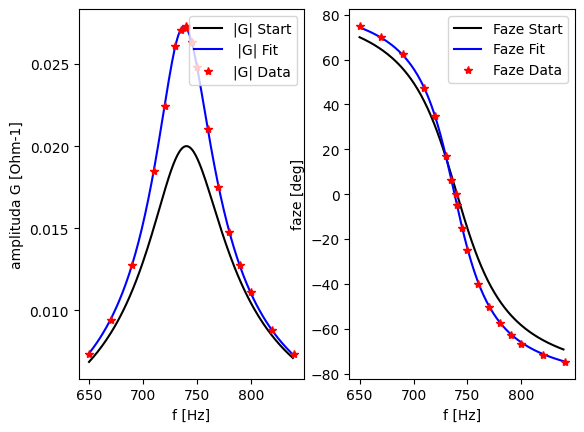

In [3]:
#program v pythonu 3.8 na fitovani velikosti vodivosti RLV obvodu. Vykresluje take fazi. Je potreba nainstalovat balicky numpy a lmfit
#predpoklada ze data jsou ulozena v souboru  RLCfrekv.dat,kde prvni sloupec je frekvence, druhy vodivost (v Ohm-1) a treti faze (ve stupnich)



#########HODNOTY V RADCICH NIZE JE VHODNE AKTUALIZOVAT
data=np.loadtxt('RLCfrekv.dat', skiprows=1)   # je potreba aktualizovat nazev souboru, nacteni exprimentalnich dat do pole "data", preskakuje prvni radek
R=50 #[Ohm], odhad hodnoty odporu, 
L=0.113 #[H], odhad hodnoty indukce
C=4.09e-07 #[F], odhad hodnoty kapacity.
#########HODNOTY V RADCICH VYSE JE VHODNE AKTUALIZOVAT

fdata=data[:,0]   #nacte frekvenci z prvniho sloupce
odata=fdata*2*np.pi  #prepocteni na kruhovou frekvenci
Gdata=data[:,1]  #nacte amplitudy vodivosti z druheho sloupce 
Phase=data[:,2]  #nacteni amplitudu faze z tretiho sloupce 

ParsStart = Parameters()   #definice objektu fitovacich parametru z balicku lmfit
#pri nelinearnim fitovani by mely byt startovaci hodnoty parametru relativne blizko konecnym, jinak fit nemusi dobre zkonvergovat
#zavedeni jednotlivych fitovacich parametru se startovaci fitovaci hodnotou a informaci, zda se fituje nebo ne (vary=True/False)
ParsStart.add('F', value=1/L,vary=True)   
ParsStart.add('omega0', value=1/np.sqrt(L*C),vary=True)  
ParsStart.add('alpha', value=R/(2*L),vary=True)  


#definice funkci
def Gabs(p,omega):   #absolutni velikost vodivosti, v p jsou parametry 
	# vztah (6.31), vyjadreno pomoci F, omega0 a alpha. Pri fitovani pomoci R,L,C hodnoty L a C velmi silne antikoreluji	
	return omega*p["F"]/np.sqrt((p["omega0"]**2-omega**2)**2+(2*p["alpha"]*omega)**2) 
def Gphi(p,omega):  #faze ve stupnich
	return np.arctan((p["omega0"]**2-omega**2)/(2*p["alpha"]*omega))/np.pi*180  # vztah (6.31), 

def residual(Pars, omega, Gdata):    #definice residualu: rozdilu fitovane funkce a dat, v Pars jsou parametry modelu
	return Gabs(Pars,omega) - Gdata  #zde se fituje jen rozdil absolutni hodnoty vodivosti mezi teorii a daty, ne faze

#fitovani
minner = Minimizer(residual, ParsStart, fcn_args=(odata,Gdata))  #samotne fitovani. Vola funkci residual, pouziva parametrky k fitovani Parstart
results = minner.minimize()  #ulozeni vysledku fitovani do promenne result
ParsFit= results.params   #ulozeni vyslednych hodnot fitovacich parametru do promenne ParsFit

#vypsani statistiky na obrazovku a ulozeni do souboru
print(fit_report(results))  # write error report, alternative result.params.pretty_print()
FileStatistika= open('Statistika.dat', 'w+')  #ulozeni statistiky do souboru
print(fit_report(results),file=FileStatistika)
FileStatistika.close()

#vytvoreni promennych ufloat z knihovny uncertainties pro vypocet nejen hodnot, ale i chyb. Prvni parametr je hodnota, druhy chyba
F=ufloat(ParsFit['F'], ParsFit['F'].stderr)  
omega0=ufloat(ParsFit['omega0'], ParsFit['omega0'].stderr)
alpha=ufloat(ParsFit['alpha'], ParsFit['alpha'].stderr)
# vypocet dalcich hodnot. Knihovna uncertainties k tomu automaticky vypocte chyby dle zakona sireni chyb 
L=1/F
R=2*L*alpha
C=1/(L*omega0**2)
Q=omega0/(2*alpha)
f0=omega0/(2*np.pi)
print("")
print("Vypoctene dalsi hodnoty vcetne chyb dle zakona sireni chyb s pomoci balicku uncertainties")
print("R=", R,"Ohm, L=", L*1000,"mH, C=", C*1E9,"nF,  Q=",Q, "f0=", f0, "Hz")

#vypocet startovacich a fitovacich funkci
ftheor = np.arange(np.amin(fdata), np.amax(fdata), 1)  # vytvoreni osy frekvence pro teoreticky vypocet v ramci merenych dat s krokem 1 Hz
otheor=ftheor*2*np.pi   #prepcet na kruhovou frekvenci
# vypocet startovaci funkce Gabs (v nelinerarnim fitovani by nemela by byt moc daleko od experimentalnich dat
GabsStart = Gabs(ParsStart,otheor)  
GphiStart = Gphi(ParsStart,otheor)  # vypocet startovaci funkce Gphi
GabsFit = Gabs(ParsFit,otheor)  # vypocet nafitovane funkce Gabs
GphiFit = Gphi(ParsFit,otheor)  # vypocet nafitovane funkce Gphi

#ulozeni startovaci a nafitovanych zavislosti do souboru
FileFitSpekta= open('FitSpekta.dat', 'w+')
print ("f[Hz]", "\t", "GabsStart",  "\t", "GphiStart", "\t", "GabsFit",  "\t", "GphiFit", file=FileFitSpekta)
for i in range(len(ftheor)):
    print (ftheor[i],"\t",GabsStart[i],  "\t",GphiStart[i], "\t", GabsFit[i],  "\t",GphiFit[i], file=FileFitSpekta)
FileFitSpekta.close()

#vykresleni obrazku amplitudy a faze
fig, (ax1, ax2) = plt.subplots(1, 2)  
#levy obrazek amplitudy
ax1.plot(ftheor,GabsStart,'k-',label='|G| Start')
ax1.plot(ftheor,GabsFit,'b-',label=' |G| Fit')
ax1.plot(fdata,Gdata,'r*',label='|G| Data')
ax1.legend(loc='upper right', shadow=False)
ax1.set(xlabel='f [Hz]', ylabel='amplituda G [Ohm-1]')
#pravy obrazek faze
ax2.plot(ftheor,GphiStart,'k-',label='Faze Start')
ax2.plot(ftheor,GphiFit,'b-',label='Faze Fit')
ax2.plot(fdata,Phase,'r*',label='Faze Data')
ax2.legend(loc='upper right', shadow=False)
ax2.set(xlabel='f [Hz]', ylabel='faze [deg]')
plt.savefig('vodivost.pdf')
plt.show()



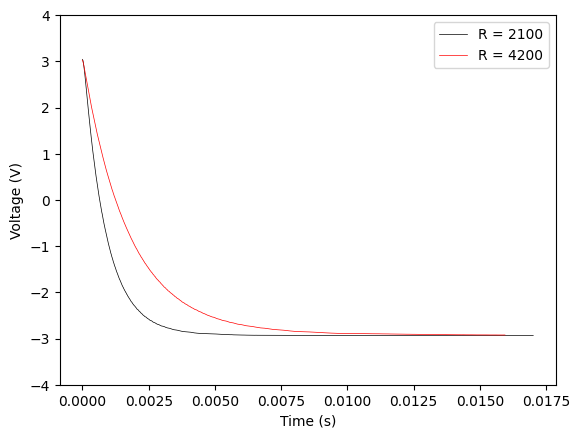

Fitted parameters for R1: A = 6.2306+/-0.0027, tau = 0.0008626+/-0.0000006, C = -2.93273+/-0.00035
Fitted parameters for R2: A = 5.9603+/-0.0018, tau = 0.0017534+/-0.0000009, C = -2.9092+/-0.0004


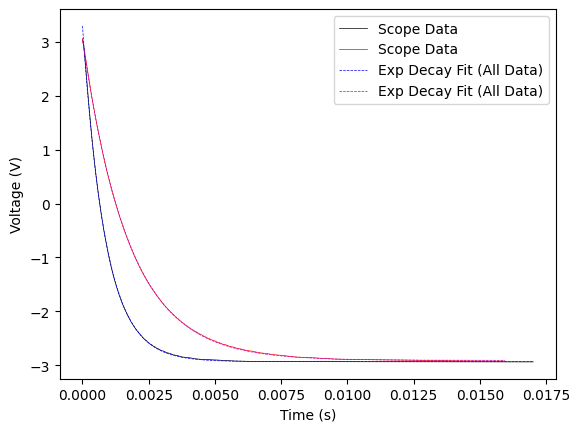

Damping constant: 1159.3+/-0.8
Damping constant2: 570.33+/-0.29
4637.10+/-0.34
R = 2180+/-4
R2 = 4234+/-8


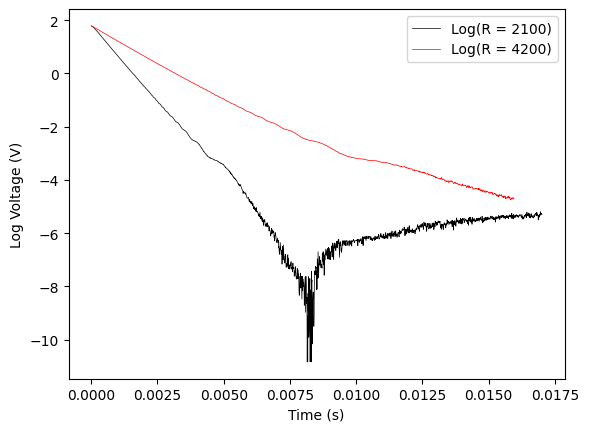

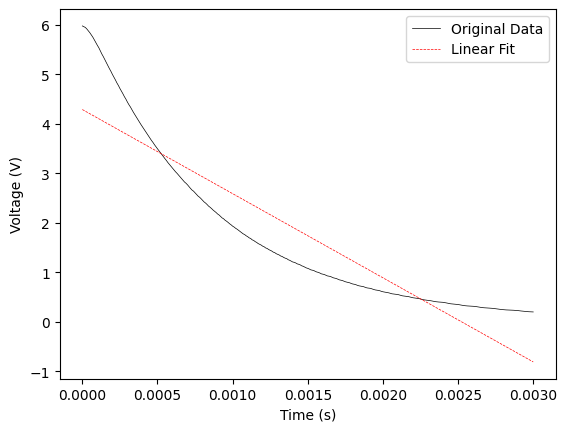

Linear approximation coefficients: slope = -1698.0109616743316, intercept = 4.287305578259005


In [4]:
from uncertainties import unumpy as unp




# Import the data from scope0.csv
scope_data = np.loadtxt('scope_3.csv', delimiter=',', skiprows=2)
scope2_data = np.loadtxt('scope_4.csv', delimiter=',', skiprows=2)
scope_data[:, 2] *= -1
scope2_data[:, 2] *= -1


# Plot the first and second columns with labels for both scopes
plt.plot(scope_data[:, 0], scope_data[:, 2], 'k-', label='R = 2100', linewidth=0.5)
plt.plot(scope2_data[:, 0], scope2_data[:, 2], 'r-', label='R = 4200', linewidth=0.5)
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.ylim(-4, 4)
plt.show()
# Find local maxima in the second column
peaks, _ = find_peaks(scope_data[:, 2])
peaks = peaks[scope_data[peaks, 0] > 0]

minima, _ = find_peaks(-scope_data[:, 2])
minima = minima[scope_data[minima, 0] > -1]

if len(peaks) < 50 and len(minima) < 50:
    # Plot the local maxima and minima
    plt.plot(scope_data[:, 0], scope_data[:, 2], '-', label='Scope Data')
    plt.plot(scope_data[peaks, 0], scope_data[peaks, 2], 'ro', markersize=3, label='Peaks')
    plt.plot(scope_data[minima, 0], scope_data[minima, 2], 'go', markersize=3, label='Minima')
    plt.xlabel('Time (s)')
    plt.ylabel('Voltage (V)')
    plt.ylim(-4, 8)
    plt.legend()
    plt.show()

    # Define the exponential decay function
    def exp_decay(t, A, tau, C):
        return A * np.exp(-t / tau) + C

    # Extract the time and voltage values for the peaks with t > 0
    peak_times = scope_data[peaks, 0]
    peak_voltages = scope_data[peaks, 2]

    # Filter the peaks to include only those with t > 0
    positive_peak_indices = peak_times > 0
    positive_peak_times = peak_times[positive_peak_indices]
    positive_peak_voltages = peak_voltages[positive_peak_indices]

    # Extract the time and voltage values for the minima with t > 0
    minima_times = scope_data[minima, 0]
    minima_voltages = scope_data[minima, 2]

    # Filter the minima to include only those with t > 0
    positive_minima_indices = minima_times > 0
    positive_minima_times = minima_times[positive_minima_indices]
    positive_minima_voltages = minima_voltages[positive_minima_indices]
    # Fit the exponential decay function to the positive peaks and minima
    popt_peaks, pcov_peaks = curve_fit(exp_decay, positive_peak_times, positive_peak_voltages, p0=(1, 1, 0))
    popt_minima, pcov_minima = curve_fit(exp_decay, positive_minima_times, positive_minima_voltages, p0=(1, 1, 0))

    # Extract uncertainties
    perr_peaks = np.sqrt(np.diag(pcov_peaks))
    perr_minima = np.sqrt(np.diag(pcov_minima))

    # Create ufloat variables for the fitted parameters
    A_peaks = ufloat(popt_peaks[0], perr_peaks[0])
    tau_peaks = ufloat(popt_peaks[1], perr_peaks[1])
    C_peaks = ufloat(popt_peaks[2], perr_peaks[2])

    A_minima = ufloat(popt_minima[0], perr_minima[0])
    tau_minima = ufloat(popt_minima[1], perr_minima[1])
    C_minima = ufloat(popt_minima[2], perr_minima[2])

    # Print the fitted parameters with uncertainties
    print(f"Fitted parameters for peaks: A = {A_peaks}, tau = {tau_peaks}, C = {C_peaks}")
    print(f"Fitted parameters for minima: A = {A_minima}, tau = {tau_minima}, C = {C_minima}")

    # Plot the fitted exponential decay curves for peaks and minima
    t_fit = np.linspace(min(positive_peak_times.min(), positive_minima_times.min()), max(positive_peak_times.max(), positive_minima_times.max()), 100)
    voltage_fit_peaks = exp_decay(t_fit, *popt_peaks)
    voltage_fit_minima = exp_decay(t_fit, *popt_minima)

    plt.plot(positive_peak_times, positive_peak_voltages, 'ro', label='Peaks')
    plt.plot(positive_minima_times, positive_minima_voltages, 'go', label='Minima')
    plt.plot(t_fit, voltage_fit_peaks, 'b-', label='Exp Decay Fit (Peaks)')
    plt.plot(t_fit, voltage_fit_minima, 'm-', label='Exp Decay Fit (Minima)')
    plt.xlabel('Time (s)')
    plt.ylabel('Voltage (V)')
    plt.legend()
    plt.show()

    # Plot the original data, fitted peaks, and fitted minima
    average_C = (popt_peaks[2] + popt_minima[2]) / 2
    print((C_peaks+C_minima)/2)
    plt.plot(scope_data[:, 0], scope_data[:, 2],  'k-', label='Scope Data')
    plt.plot(t_fit, voltage_fit_peaks, '--', label='Exp Decay Fit (Peaks)', linewidth=0.5)
    plt.plot(t_fit, voltage_fit_minima, '--', label='Exp Decay Fit (Minima)', linewidth=0.5)
    plt.axhline(y=average_C, color='k', linestyle='--', label=f'Uf = {average_C:.2f}', linewidth=0.5)

    plt.xlabel('Time (s)')
    plt.ylabel('Voltage (V)')
    plt.ylim(-4, 8)
    plt.legend()
    plt.show() 

    damping_constant = 1 / tau_all
    alpha = damping_constant
    print(f"Damping constant: {damping_constant}")
    R = 2*L*alpha
    print('R =', R)

    
    time_differences = np.diff(positive_peak_times)
    average_time_between_peaks = unp.uarray(time_differences[:7], 0).mean()
    print(f"Average time between first seven peaks: {average_time_between_peaks}")
    frequency_of_oscillation = 1 / (average_time_between_peaks)
    print(f"Frequency of oscillation: {frequency_of_oscillation}")
    omegad = 2 * np.pi * frequency_of_oscillation
    print('omegad =', omegad)
    omega = unp.sqrt(omegad**2 + alpha**2)
    print('omega0 =', omega)
    f0 = omega / (2 * np.pi)
    print('f0 =', f0)
    
if len(peaks) > 50 and len(minima) > 50:

    # Define the exponential decay function
    def exp_decay(t, A, tau, C):
        return A * np.exp(-t / tau) + C

    # Extract the time and voltage values for all data points
    times = scope_data[:, 0]
    voltages = scope_data[:, 2]
    times2 = scope2_data[:, 0]
    voltages2 = scope2_data[:, 2]

    # Fit the exponential decay function to all data points with better initial guesses
    popt_all, pcov_all = curve_fit(exp_decay, times, voltages, p0=(1, 1e-4, 0))
    popt_all2, pcov_all2 = curve_fit(exp_decay, times2, voltages2, p0=(1, 1e-4, 0))

    # Extract uncertainties
    perr_all = np.sqrt(np.diag(pcov_all))
    perr_all2 = np.sqrt(np.diag(pcov_all2))

    # Create ufloat variables for the fitted parameters
    A_all = ufloat(popt_all[0], perr_all[0])
    tau_all = ufloat(popt_all[1], perr_all[1])
    C_all = ufloat(popt_all[2], perr_all[2])
    A_all2 = ufloat(popt_all2[0], perr_all2[0])
    tau_all2 = ufloat(popt_all2[1], perr_all2[1])
    C_all2 = ufloat(popt_all2[2], perr_all2[2])


    # Print the fitted parameters with uncertainties
    print(f"Fitted parameters for R1: A = {A_all}, tau = {tau_all}, C = {C_all}")
    print(f"Fitted parameters for R2: A = {A_all2}, tau = {tau_all2}, C = {C_all2}")

    # Plot the fitted exponential decay curve for all data
    voltage_fit_all = exp_decay(times, *popt_all)
    voltage_fit_all2 = exp_decay(times2, *popt_all2)

    plt.plot(times, voltages, 'k-', label='Scope Data', linewidth=0.5)
    plt.plot(times2, voltages2, 'r-', label='Scope Data', linewidth=0.5)
    plt.plot(times, voltage_fit_all, 'b--', label='Exp Decay Fit (All Data)', linewidth=0.5)
    plt.plot(times2, voltage_fit_all2, 'm--', label='Exp Decay Fit (All Data)', linewidth=0.5)
    plt.xlabel('Time (s)')
    plt.ylabel('Voltage (V)')
    plt.legend()
    plt.show()




    damping_constant = 1 / tau_all
    damping_constant2 = 1 / tau_all2
    alpha = damping_constant
    alpha2 = damping_constant2
    print(f"Damping constant: {damping_constant}")
    print(f"Damping constant2: {damping_constant2}")
    print(omega0)
    R = L*(omega0**2+alpha**2)/alpha
    R2 = L*(omega0**2+alpha2**2)/alpha2
    print('R =', R)
    print('R2 =', R2)


    # Subtract -2.93273 from the data
    scope_data[:, 2] -= -2.93273
    scope2_data[:, 2] -= -2.93273
    # Apply logarithm to the voltage data
    log_scope_data = np.log(np.abs(scope_data[:, 2]))
    log_scope2_data = np.log(np.abs(scope2_data[:, 2]))

    # Plot the logarithm of the voltage data
    plt.plot(scope_data[:, 0], log_scope_data, 'k-', label='Log(R = 2100)', linewidth=0.5)
    plt.plot(scope2_data[:, 0], log_scope2_data, 'r-', label='Log(R = 4200)', linewidth=0.5)
    plt.legend()
    plt.xlabel('Time (s)')
    plt.ylabel('Log Voltage (V)')
    plt.show()

    # Filter the data for the time range from t=0 to t=0.003
    time_range = (scope_data[:, 0] >= 0) & (scope_data[:, 0] <= 0.003)
    filtered_times = scope_data[time_range, 0]
    filtered_voltages = scope_data[time_range, 2]

    # Perform linear approximation
    coefficients = np.polyfit(filtered_times, filtered_voltages, 1)
    linear_fit = np.polyval(coefficients, filtered_times)

    # Plot the original data and the linear approximation
    plt.plot(filtered_times, filtered_voltages, 'k-', label='Original Data', linewidth=0.5)
    plt.plot(filtered_times, linear_fit, 'r--', label='Linear Fit', linewidth=0.5)
    plt.xlabel('Time (s)')
    plt.ylabel('Voltage (V)')
    plt.legend()
    plt.show()

    # Print the approximation coefficients
    print(f"Linear approximation coefficients: slope = {coefficients[0]}, intercept = {coefficients[1]}")


